# Simple FEM for one dimensional heat transfer problem

The problem for $T(t,x)$ is stated as
$$
\frac{\partial T}{\partial t} - \alpha \Delta T = 0 \quad \text{for} \quad x \in [0,L], t \in [0, Z]
$$
with a constant heat conductivity $\alpha$ subject to the boundary condition
$$
T(t, x=0) = 0
$$
and the initial condition
$$
T(t=0, x) = \cos(2\pi x)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nutils import function, mesh, solver
from nutils.expression_v2 import Namespace

from global_constants import L, Z, alpha

ns = Namespace()
ns.α = alpha

# Create topology (connectivity of mesh) and geometry (position of mesh)
N = 10
topo, geom = mesh.rectilinear([np.linspace(0, L, N)])

# Define the geometry variable as well as gradients, normal and jacobians on the domain.
ns.x = geom
ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', 'dS'))

## Prepare visualization
This code defines a python function `plot_line` to plot a *nutils* function (e.g. basis or solution variables) on the domain  $x \in [0, 1]$

In [2]:
bezier = topo.sample('bezier', 32)
nanjoin = lambda array, tri: np.insert(array.take(tri.flat, 0).astype(float), slice(tri.shape[1], tri.size, tri.shape[1]), np.nan, axis=0)
sampled_x = nanjoin(bezier.eval('x_0' @ ns), bezier.tri)
def plot_line(func, **arguments):
  plt.plot(sampled_x, nanjoin(bezier.eval(func, **arguments), bezier.tri))
  plt.xlabel('x_0')
  plt.xticks(np.linspace(0, L, 5))

## Basis
A *nutils* basis is a vector-based function that evalautes at any given point x on the domain to the array of basis functions.

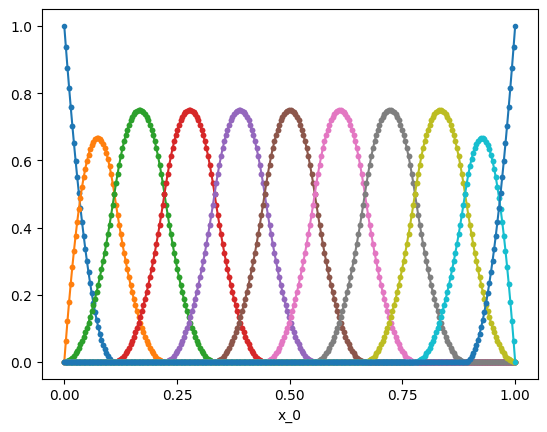

In [3]:
ns.basis = topo.basis('spline', degree=2)
plot_line(ns.basis)

## Problem formulation

The weak form of the equation to be solved is 

$$ 
 \int_\Omega \frac{\partial T}{\partial t} v dV  + \int_\Omega \alpha \nabla T \cdot \nabla v dV = 0.
$$

The Dirichlet boundary condition at the left end is expressed as 

$$ 
 \underset{T}{\min} \int_{\partial\Omega_D} (T-1)^2 dS = 0.
$$

In [4]:
# The solution function to evaluate results is a dot product of the argument 'Th' with the basis)
ns.T = function.dotarg('lhs', ns.basis)

# By linearity the test function v can be replaced by the basis that spans its space. 
residual = topo.integral('α ∇_i(basis_n) ∇_i(T) dV' @ ns, degree=2)

# By linearity the test function v can be replaced by the basis that spans its space.
inertia = topo.integral('T basis_n dV' @ ns, degree=2)

# Dirichlet boundary condition
sqr = topo.boundary['left'].integral('(T - 1)^2 dS' @ ns, degree=2)
constrain = solver.optimize('lhs', sqr, droptol=1e-15)

# Initial conditions
x0 = np.linspace(0, L, N+1)
lhs0 = np.cos(2.0*np.pi*x0)

# Solve the system
dt = 1e-4
lhsiter = iter(solver.cranknicolson('lhs', residual=residual, inertia=inertia, timestep=dt, lhs0=lhs0, constrain=constrain))

optimize > solve > solving 1 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 0e+00
optimize > constrained 1/11 dofs
optimize > optimum value 0.00e+00


/Users/meyernil/miniforge3/envs/nutils/lib/python3.9/site-packages/nutils/matrix/_base.py:246: RuntimeWarning: divide by zero encountered in scalar divide
  treelog.debug('residual decreased by {:.1f} orders using {} krylov vectors'.format(numpy.log10(resnorm/newresnorm), len(krylov)))


## Integrate in time

newton 0% > solve > solving 10 dof system to tolerance 7e-03 using arnoldi solver
newton 0% > solve > solver returned with residual 9e-16
newton 0% > estimated residual minimum at 100% of update vector
newton 0% > update accepted at relaxation 1.0
newton 100% > converged in 1 steps to residual 2.4e-13
newton 0% > solve > solving 10 dof system to tolerance 6e-03 using arnoldi solver
newton 0% > solve > solver returned with residual 2e-15
newton 0% > estimated residual minimum at 100% of update vector
newton 0% > update accepted at relaxation 1.0
newton 100% > converged in 1 steps to residual 2.1e-13
newton 0% > solve > solving 10 dof system to tolerance 6e-03 using arnoldi solver
newton 0% > solve > solver returned with residual 5e-16
newton 0% > estimated residual minimum at 100% of update vector
newton 0% > update accepted at relaxation 1.0
newton 100% > converged in 1 steps to residual 2.0e-13
newton 0% > solve > solving 10 dof system to tolerance 6e-03 using arnoldi solver
newton 0%

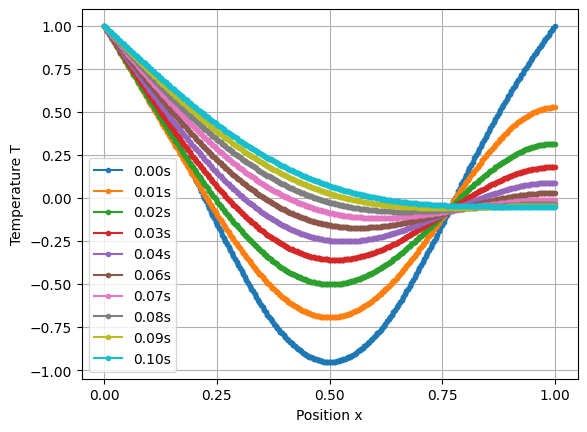

In [5]:
results = [lhs0]
for i in range(1, int(Z/dt)):
    res = next(lhsiter)
    if i%100 == 0:
        results.append(res)

for res in results:
    plot_line(ns.T, lhs=res)
plt.legend([f"{t:.2f}s" for t in np.linspace(0, Z, 10) ])
plt.xlabel("Position x")
plt.ylabel("Temperature T")
plt.grid()
